In [1]:
import pandas as pd
from plot_params import *
import pandas as pd
from scipy.stats import ks_2samp
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
data=pd.read_csv(outdir / 'Human_annotated_30bp.csv.gz', index_col=0)  # from 0_join_data-human-30bp.ipynb

basedir = Path('/tscc/nfs/home/hsher/ps-yeolab5/karen_data/eclip_model_scores_human_30bp/output/')
for f in basedir.glob('*.score.csv'):
    name = f.name.split('.')[0]
    df = pd.read_csv(f,
                    index_col = 0)
    df.set_index('ID', inplace = True)
    df.rename({'dlogodds_pred': name}, axis = 1, inplace = True)


    data[name]=df[name]

/tmp/ipykernel_4035771/2032041368.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[name]=df[name]
/tmp/ipykernel_4035771/2032041368.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[name]=df[name]
/tmp/ipykernel_4035771/2032041368.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  

In [2]:
data['annotation']=data.apply(
    lambda row: 'UTR5' if row['start_annotation']=='UTR5' and row['end_annotation']=='UTR5' else
     'UTR3' if row['start_annotation']=='UTR3' and row['end_annotation']=='UTR3' else 'CDS', axis = 1)

/tmp/ipykernel_4035771/1127195565.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['annotation']=data.apply(


In [3]:
# data.to_csv(outdir / 'Human_annotated_RBPNet.csv.gz')

<Axes: >

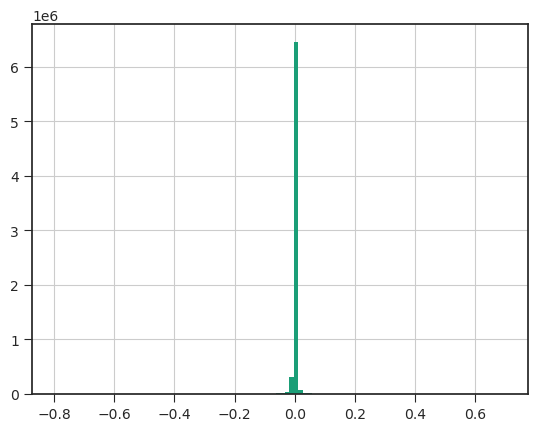

In [4]:
data['difference'].hist(bins = 100)

In [5]:

data['difference_bin'] = pd.cut(data['difference'], bins = [-np.inf, -0.1, 0.1, np.inf],
                               labels = ['<-0.1', 'middle', '>0.1'])

/tmp/ipykernel_4035771/4156597192.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['difference_bin'] = pd.cut(data['difference'], bins = [-np.inf, -0.1, 0.1, np.inf],


In [6]:

fdr_thres = 0.2
stat_all = []
for exp in data.columns[9:-2]:
    for cat in ['<-0.1', '>0.1']:
        sample = data.loc[(data['difference_bin']==cat),
                                    exp]
        bg = data.loc[          
                                    (data['difference_bin']=='middle'), exp]
        ks, pv = ks_2samp(sample, 
                          bg, alternative='two-sided')
        
        median_difference = sample.median() - bg.median()
        stat_all.append([ks, pv, exp, cat, median_difference])
        
stat_all = pd.DataFrame(stat_all, 
                        columns = ['KS statistics', 'pvalue', 'RBPNet_model', 'category', 'median difference'])




In [7]:
stat_all['sig'],stat_all['FDR'] = fdrcorrection(stat_all['pvalue'], alpha = fdr_thres)
#stat_all['l2or'] = np.log2(stat_all['odds ratio'])
stat_all['-log10 FDR']= -np.log10(stat_all['FDR']+stat_all.loc[stat_all['pvalue']>0, 'pvalue'].min())

In [8]:
stat_all.loc

In [9]:
tabledir=Path('/tscc/nfs/home/hsher/ps-yeolab5/ENCODE_paper_tables')
annotation = pd.read_csv(tabledir/'Hierachial_class.csv')
syngo = pd.read_excel('synGo/syngo_genes.xlsx')

In [10]:
stat_all['RBP_official']=stat_all['RBPNet_model'].map(annotation.set_index('id')['RBP_official'])
stat_all['is_SynGo'] = stat_all['RBP_official'].isin(syngo['hgnc_symbol'])
stat_all.to_csv(outdir / 'neural_network_enrichment_human_30bp.csv')

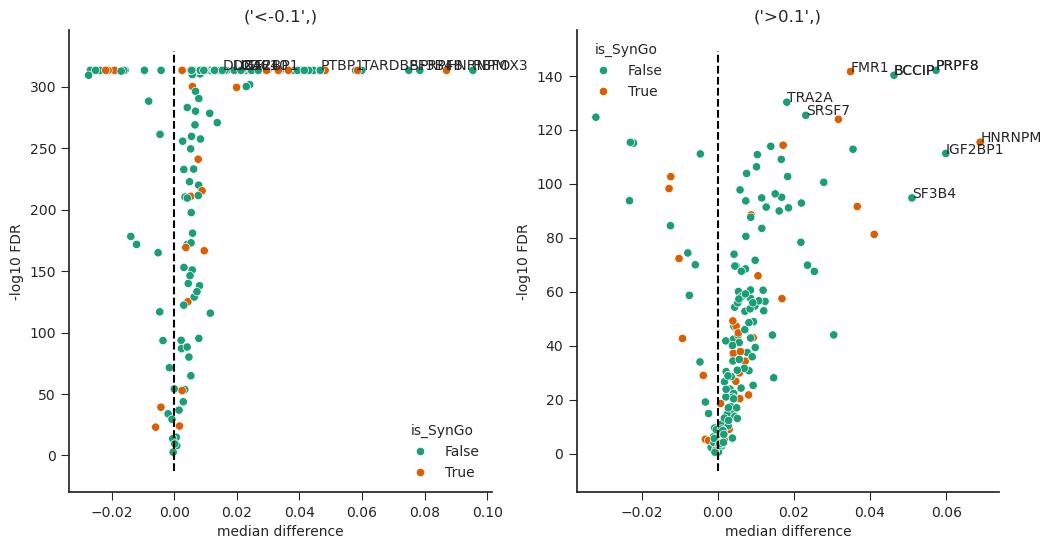

In [11]:
f, axes = plt.subplots(1,2, figsize = (12,6))
for ax, (name, group) in zip(axes.flatten(),stat_all.groupby(by = ['category'])):
    sns.scatterplot(data = group, x = 'median difference', y = '-log10 FDR', ax = ax, hue = 'is_SynGo')
    ax.set_title(name)
    sig1 = group.loc[(group['sig'])].sort_values(by = 'median difference', ascending = False).iloc[:5]
    sig2 = group.loc[(group['sig'])].sort_values(by = '-log10 FDR', ascending = False).iloc[:5]
    sig = pd.concat([sig1, sig2], axis = 0)
    for index, row in sig.iterrows():
        ax.text(row['median difference'], row['-log10 FDR'], row['RBPNet_model'].split('_')[0])
    ax.vlines(x = 0, ymin = ax.get_ylim()[0],ymax = ax.get_ylim()[1], linestyle = 'dashed', color = 'black')
sns.despine()

In [12]:
stat_all.loc[(stat_all['category']=='<-0.1')&(stat_all['sig'])].sort_values(by = 'median difference')

,KS statistics,pvalue,RBPNet_model,category,median difference,sig,FDR,-log10 FDR,RBP_official,is_SynGo
246,0.147070,1.664640e-310,FAM120A_HepG2_ENCSR987NYS,<-0.1,-0.027328,True,5.702627e-310,309.243879,FAM120A,False
12,0.185807,0.000000e+00,U2AF1_HepG2_ENCSR328LLU,<-0.1,-0.026745,True,0.000000e+00,313.213984,U2AF1,False
288,0.199434,0.000000e+00,XRN2_K562_ENCSR657TZB,<-0.1,-0.025095,True,0.000000e+00,313.213984,XRN2,False
78,0.171691,0.000000e+00,HNRNPA1_HepG2_ENCSR769UEW,<-0.1,-0.024857,True,0.000000e+00,313.213984,HNRNPA1,True
180,0.261945,0.000000e+00,ILF3_HepG2_ENCSR786TSC,<-0.1,-0.023646,True,0.000000e+00,313.213984,ILF3,False
...,...,...,...,...,...,...,...,...,...,...
300,0.287866,0.000000e+00,TARDBP_HepG2_4110,<-0.1,0.059930,True,0.000000e+00,313.213984,TARDBP,False
70,0.242327,0.000000e+00,SF3B4_HepG2_ENCSR279UJF,<-0.1,0.074914,True,0.000000e+00,313.213984,SF3B4,False
84,0.262626,0.000000e+00,PRPF8_HepG2_ENCSR121NVA,<-0.1,0.078450,True,0.000000e+00,313.213984,PRPF8,False
40,0.233155,0.000000e+00,HNRNPM_K562_ENCSR412NOW,<-0.1,0.086982,True,0.000000e+00,313.213984,HNRNPM,True


In [13]:
stat_all.loc[stat_all['RBPNet_model'].str.contains('FMR')]

,KS statistics,pvalue,RBPNet_model,category,median difference,sig,FDR,-log10 FDR,RBP_official,is_SynGo
266,0.180356,0.000000e+00,FMR1_K562_ENCSR331VNX,<-0.1,0.033256,True,0.000000e+00,313.213984,FMR1,True
267,0.191997,9.256057e-143,FMR1_K562_ENCSR331VNX,>0.1,0.034897,True,2.239578e-142,141.649834,FMR1,True


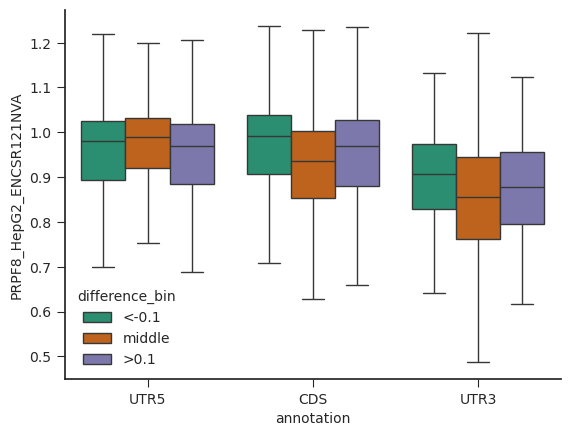

In [14]:
sns.boxplot(data, x = 'annotation', 
            y = 'PRPF8_HepG2_ENCSR121NVA', 
            hue = 'difference_bin', 
            showfliers=False)
sns.despine()

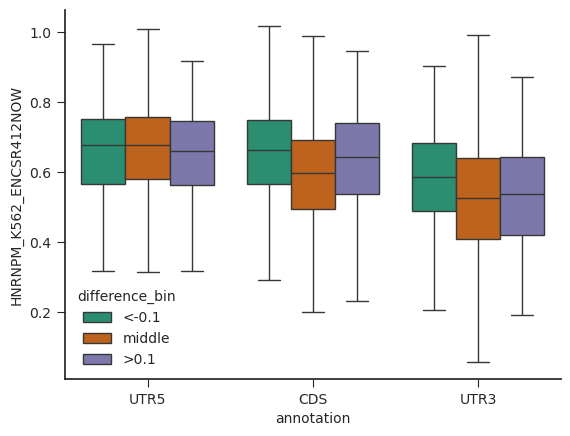

In [15]:
sns.boxplot(data, x = 'annotation', 
            y = 'HNRNPM_K562_ENCSR412NOW', 
            hue = 'difference_bin', 
            showfliers=False)
sns.despine()

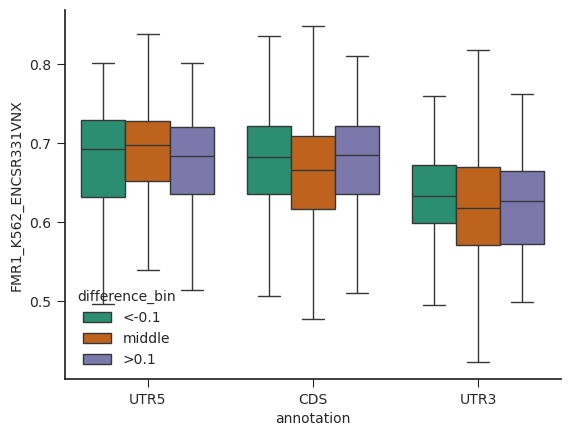

In [16]:
sns.boxplot(data, x = 'annotation', 
            y = 'FMR1_K562_ENCSR331VNX', 
            hue = 'difference_bin', 
            showfliers=False)
sns.despine()

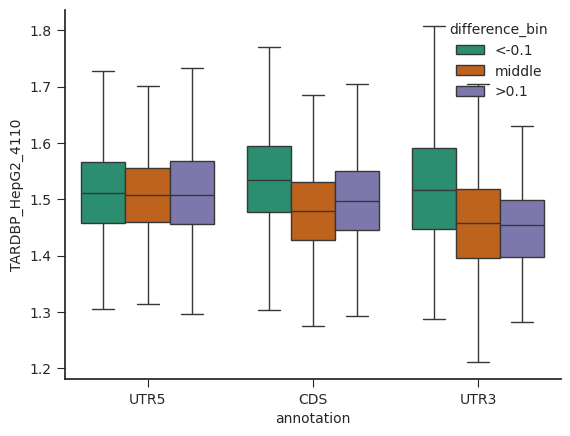

In [17]:
sns.boxplot(data, x = 'annotation', 
            y = 'TARDBP_HepG2_4110', 
            hue = 'difference_bin', 
            showfliers=False)
sns.despine()

In [18]:

stat = []
for exp in data.columns[9:-2]:
    for region in ['UTR5', 'CDS', 'UTR3']:
        for cat in ['<-0.1', '>0.1']:
            ks, pv = ks_2samp(data.loc[(data['annotation']==region)&
                                        (data['difference_bin']==cat),
                                        exp], 
                                        data.loc[(data['annotation']==region)&
                                        (data['difference_bin']=='middle'),
                                        exp], alternative='two-sided')
            stat.append([ks, pv, exp, cat, region])
        
    

In [19]:
stat = pd.DataFrame(stat, columns = ['KS statistics', 'pvalue', 'RBPNet_model', 'category', 'annotation'])

In [20]:
stat['RBP_official']=stat['RBPNet_model'].map(annotation.set_index('id')['RBP_official'])
stat['is_SynGo'] = stat['RBP_official'].isin(syngo['hgnc_symbol'])
stat.to_csv(outdir / 'neural_network_enrichment_human_30bp_region.csv')

In [21]:
data.to_csv(outdir / 'neural_network_scores_human_30bp.csv.gz')

In [22]:
data

,Unnamed: 0,transcript_id,deletion_index_start,deletion_index_end,difference,synapse_probability,start_annotation,end_annotation,subseq,DDX41_K562_5081,...,HNRNPM_HepG2_ENCSR267UCX,DDX5_K562_5094,EIF2B5_K562_5020,GRSF1_HepG2_ENCSR668MJX,CTCF_K562_4065,PTBP1_K562_5015,BUD13_K562_ENCSR663WES,ZNF800_K562_ENCSR586DGV,annotation,difference_bin
0,0,ENST00000000233,0,30,0.000000,0.044434,UTR5,UTR5,CTGCTGCTGCTGCGCCCCATCCCCCCGCGG,0.621414,...,0.788839,0.518209,0.925792,1.056194,0.848789,1.077255,0.794077,1.044325,UTR5,middle
1,1,ENST00000000233,15,45,0.000000,0.044434,UTR5,UTR5,CCCATCCCCCCGCGGCCGGCCAGTTCCAGC,0.645101,...,0.744100,0.567221,0.867844,1.051970,0.834800,1.078154,0.808794,1.022958,UTR5,middle
2,2,ENST00000000233,30,60,0.000000,0.044434,UTR5,UTR5,CCGGCCAGTTCCAGCCCGCACCCCGCGTCG,0.677037,...,0.761853,0.599932,0.889403,1.038438,0.839993,1.041651,0.784075,1.021055,UTR5,middle
3,3,ENST00000000233,45,75,0.000000,0.044434,UTR5,UTR5,CCGCACCCCGCGTCGGTGCCCGCGCCCCTC,0.608661,...,0.796313,0.547680,0.841227,1.048819,0.860952,1.044563,0.765088,1.027494,UTR5,middle
4,4,ENST00000000233,60,90,-0.001953,0.042480,UTR5,CDS,GTGCCCGCGCCCCTCCCCGGGCCCCGCCAT,0.578035,...,0.743185,0.501922,0.834412,1.037641,0.829843,1.026855,0.763847,1.003426,CDS,middle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6969881,6969881,ENST00000707136,2835,2865,0.000000,0.018433,CDS,CDS,TGTGTCCACTCAGGGTTAAATGGATTAAGG,0.662230,...,0.784039,0.610051,0.887840,1.087062,0.852174,1.001173,0.745264,0.982547,CDS,middle
6969882,6969882,ENST00000707136,2850,2880,0.000000,0.018433,CDS,CDS,TTAAATGGATTAAGGGCGGTGCAAGATGTG,0.699685,...,0.880285,0.661205,0.940249,1.097334,0.844719,1.001618,0.797633,1.037162,CDS,middle
6969883,6969883,ENST00000707136,2865,2895,0.000000,0.018433,CDS,CDS,GCGGTGCAAGATGTGCTTTGTTAAACAGAT,0.628417,...,0.773453,0.547205,0.904130,1.058125,0.821717,0.995255,0.724446,1.023199,CDS,middle
6969884,6969884,ENST00000707136,2880,2910,0.000000,0.018433,CDS,CDS,CTTTGTTAAACAGATGCTTGAAGGCAGCAT,0.668094,...,0.821202,0.578899,0.908439,1.077592,0.840432,1.020900,0.772579,1.023962,CDS,middle
